In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from json import load
import tifffile
from tqdm import tqdm
from skimage.draw import polygon
from matplotlib import rcParams
from glasbey import create_palette
import napari
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA



In [2]:
centroids = pd.read_csv(r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_03_18_trk\pieces\centroids_2d_from_stack.csv")

centroids["px_area"] = centroids["px_area"].abs()
centroids = centroids[centroids["px_area"] < 300]


subset = centroids[centroids["px_area"] > 15]
subset = centroids
X = subset[["timepoint", "px_z", "px_y", "px_x"]].values
X[:, 0] = X[:, 0] - X[:, 0].min()
X = np.round(X)
X = np.nan_to_num(X)
X = X.astype(np.int32)

pal = create_palette(3)
print(pal)
mapper = {"top": pal[0], "bottom": pal[1], "poles": pal[2]}
color = [mapper[ct] for ct in subset["mesh_name"]]

viewer = napari.Viewer()
viewer.theme = "light"
viewer.add_points(X, size=np.power(subset["px_area"], 1/2) / .66, face_color=color, name="new_centroids")

napari.run()

['#d21820', '#1869ff', '#008a00']


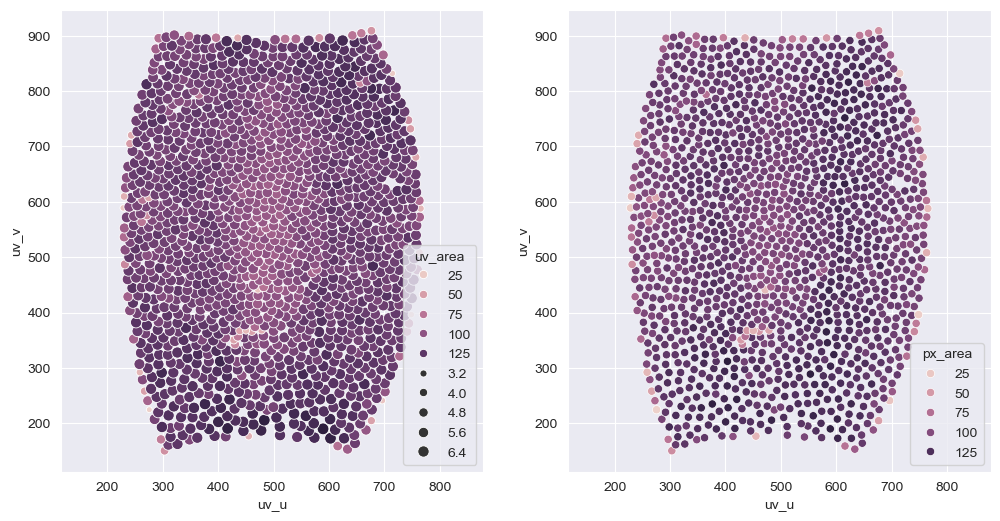

In [4]:
subset = centroids[centroids["mesh_name"] == "bottom"]
subset = subset[subset["timepoint"] == 200]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.scatterplot(subset, x="uv_u", y="uv_v", hue="uv_area", ax=axes[0], size=(subset["uv_area"] / np.pi)**(1/2))
axes[0].axis("equal")

sns.scatterplot(subset, x="uv_u", y="uv_v", hue="px_area", ax=axes[1])
axes[1].axis("equal")

plt.show()

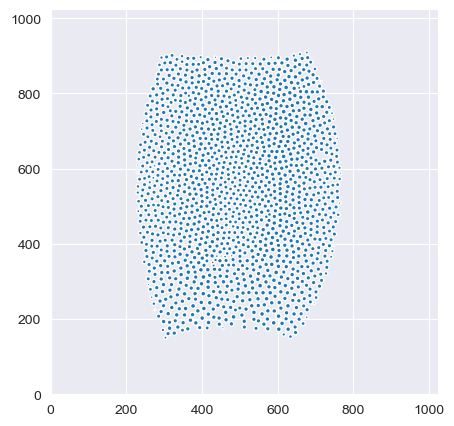

In [5]:
from matplotlib.patches import Circle

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plt.xlim(0, 1024)
plt.ylim(0, 1024)

for x, y, s in zip(subset["uv_u"], subset["uv_v"], subset["px_area"]):

    r = (s / np.pi)**(1/2)

    circle = Circle((x, y), r)
    ax.add_patch(circle)

plt.show()

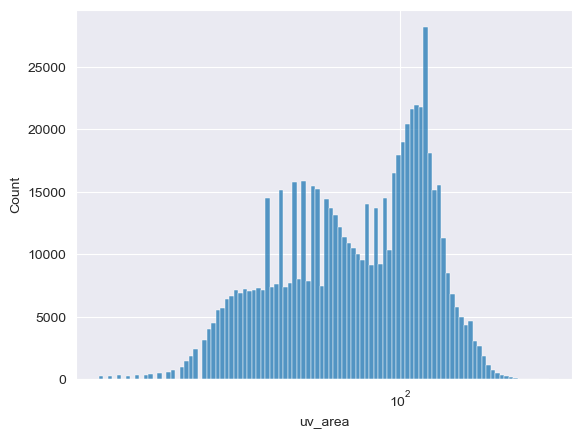

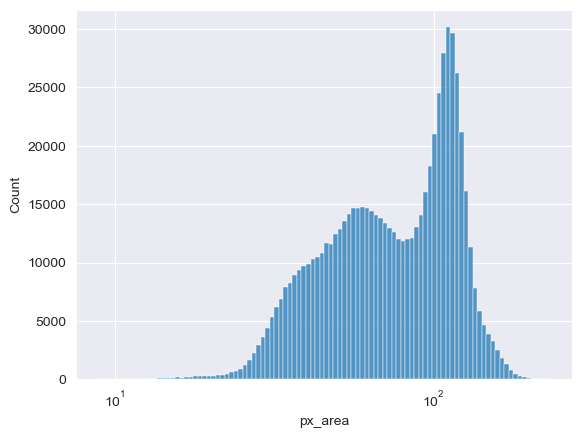

In [6]:
sns.histplot(centroids["uv_area"], bins=100, log_scale=True)
plt.show()

sns.histplot(centroids["px_area"], bins=100, log_scale=True)
plt.show()

bottom
top


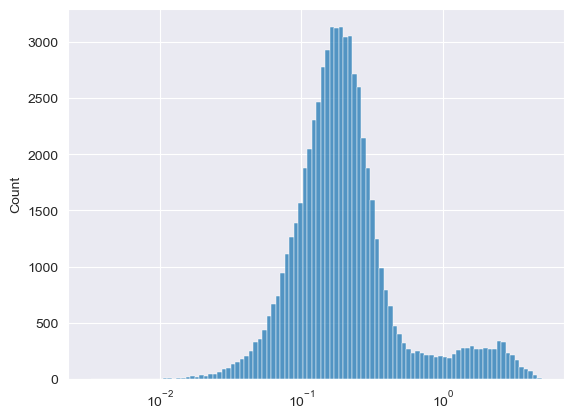

poles


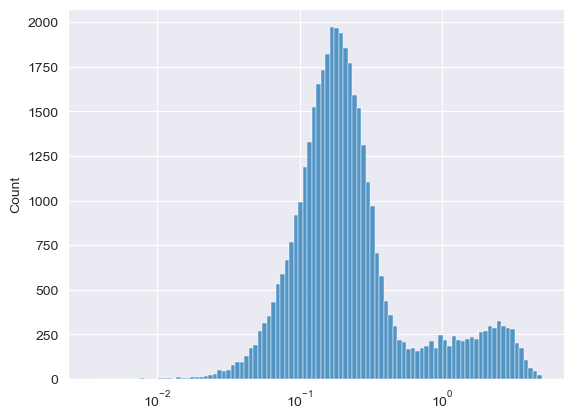

['#d21820', '#1869ff', '#008a00']


In [7]:

# def remove_dup_centroids(mesh_centroids, max_distance=10):
#
#     for timepoint, group in tqdm(mesh_centroids.groupby("timepoint")):
#         x = group[["centroid-1", "centroid-2"]].values
#         dist = cdist(x, x)
#
#         np.fill_diagonal(dist, np.inf)
#         close_pairs = np.argwhere(dist < max_distance)
#
#         if close_pairs.size == 0:
#             continue
#
#         to_drop = []
#
#         for i, j in close_pairs:
#             if j <= i:
#                 continue
#
#             new_centroid = (group.iloc[i][["centroid-1", "centroid-2"]].values + group.iloc[j][["centroid-1", "centroid-2"]].values) / 2
#             new_area = group.iloc[i]["area"] + group.iloc[j]["area"]
#
#             mesh_centroids.loc[group.index[i], ["centroid-1", "centroid-2"]] = new_centroid
#             mesh_centroids.loc[group.index[i], "area"] = new_area
#
#             to_drop.append(group.index[j])
#
#         mesh_centroids = mesh_centroids.drop(to_drop)
#
#     return mesh_centroids

def merge_centroids(current_centroids, centroids_to_add, max_distance=25):
    """
    Merges centroids from `centroids_to_add` into `current_centroids` if they are within `max_distance`.
    """
    axes = ["px_z", "px_y", "px_x"]

    merged_centroids = current_centroids.copy()
    add_to_drop = set()
    merged_to_drop = set()
    close_distances = []

    for timepoint in set(current_centroids["timepoint"]).intersection(set(centroids_to_add["timepoint"])):

        current = current_centroids[current_centroids["timepoint"] == timepoint]
        to_add = centroids_to_add[centroids_to_add["timepoint"] == timepoint]

        x_current = current[axes].values
        x_add = to_add[axes].values

        distances = cdist(x_current, x_add)

        close_pairs = np.argwhere(distances < max_distance)

        for i, j in close_pairs:
            close_distances.append(distances[i, j])
            # keep the centroids farthest from the edge
            if to_add.iloc[j]["uv_distance_from_edge"] < current.iloc[i]["uv_distance_from_edge"]:
                add_to_drop.add(to_add.index[j])
            else:
                merged_to_drop.add(current.index[i])


    out = pd.concat([merged_centroids.drop(merged_to_drop), centroids_to_add.drop(add_to_drop)], ignore_index=True)

    sns.histplot(close_distances, bins=100, log_scale=True)
    plt.show()
    # print(f"Merged {len(to_drop)} centroids, {len(out)} remaining.")

    return out

# new_centroids = None
#
# for mesh_name in centroids["mesh_name"].unique():
#     to_add = remove_dup_centroids(centroids[centroids["mesh_name"] == mesh_name], max_distance=2)
#
#     if new_centroids is None:
#         new_centroids = to_add
#         continue
#
#     new_centroids = merge_centroids(new_centroids, to_add, max_distance=8)

new_centroids = None

for mesh_name in ["bottom", "top", "poles"]:
    print(mesh_name)

    to_add = centroids[centroids["mesh_name"] == mesh_name]

    if new_centroids is None:
        new_centroids = to_add
        continue

    new_centroids = merge_centroids(new_centroids, to_add, max_distance=5)

X = new_centroids[["timepoint", "px_z", "px_y", "px_x"]].values
X[:, 0] = X[:, 0] - X[:, 0].min()
X = np.round(X)
X = np.nan_to_num(X)
X = X.astype(np.int32)

pal = create_palette(3)
print(pal)
mapper = {"top": pal[0], "bottom": pal[1], "poles": pal[2]}
color = [mapper[ct] for ct in new_centroids["mesh_name"]]

viewer = napari.Viewer()
viewer.theme = "light"
viewer.add_points(X, size=2* np.power(new_centroids["px_area"] / np.pi, 1/2), face_color=color, name="new_centroids")

napari.run()

In [8]:

# remove rows with na
new_centroids = new_centroids.dropna()
# make new index
new_centroids = new_centroids.reset_index(drop=True)
new_centroids["id_prev"] = new_centroids.index.astype(np.uint32)
new_centroids.to_csv(r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_03_18_trk\pieces\new_centroids.csv", index=False)

In [24]:
new_centroids

,uv_v,uv_u,px_z,px_y,px_x,uv_distance_from_edge,intensity_mean,uv_z,area_distortion,uv_area,timepoint,px_area,mesh_name,id_prev
0,185.157895,578.736842,122.638158,818.157895,163.526316,12.157895,446.705727,15.473684,0.794335,19.0,0,15.092367,bottom,0
1,188.314286,490.285714,192.707143,822.100000,139.746429,12.314286,457.567600,13.314286,0.807486,35.0,0,28.262008,bottom,1
2,189.181818,587.909091,116.022727,812.909091,166.662879,16.696390,446.671965,14.454545,0.832632,33.0,0,27.476852,bottom,2
3,207.305556,496.277778,187.451389,806.250000,129.989583,31.305556,435.237846,11.805556,0.857182,36.0,0,30.858563,bottom,3
4,207.605263,620.078947,91.993421,791.763158,177.243421,37.380937,509.221703,13.710526,0.894802,38.0,0,34.002479,bottom,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507456,866.069767,447.906977,107.005087,784.784884,302.906977,26.730274,1047.989112,12.348837,0.785543,86.0,283,67.556736,poles,507456
507457,866.522727,468.715909,118.512074,782.142045,314.664773,26.457393,998.525980,12.488636,0.780490,88.0,283,68.683096,poles,507457
507458,866.259259,482.432099,126.479167,779.604938,321.725309,25.055447,919.400761,12.728395,0.774136,81.0,283,62.705040,poles,507458
507459,865.910256,504.602564,140.171474,772.801282,330.487179,19.838506,925.170195,12.217949,0.752531,78.0,283,58.697449,poles,507459


In [21]:
# centroids = pd.read_csv(r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_02_06\pieces\centroids.csv")

# centroids

X = new_centroids[["timepoint", "intensity_mean-0", "intensity_mean-1", "intensity_mean-2"]].values
X[:, 0] = X[:, 0] - X[:, 0].min()
X = np.round(X)
X = np.nan_to_num(X)
X = X.astype(np.int32)

pal = create_palette(3)
mapper = {"top": pal[0], "bottom": pal[1], "poles": pal[2]}
color = [mapper[ct] for ct in new_centroids["mesh_name"]]

viewer = napari.Viewer()
viewer.theme = "light"
viewer.add_points(X, size=np.power(new_centroids["area"], 1/3) / .66, face_color=color, name="new_centroids")

napari.run()

In [4]:
centroids

,centroid-0,centroid-1,centroid-2,intensity_mean-0,intensity_mean-1,intensity_mean-2,area,mesh_name,timepoint
0,3.461538,840.076923,613.576923,296.931500,791.119989,83.151049,26.0,bottom,167
1,10.828169,861.340845,699.611268,348.851885,800.215257,151.136600,710.0,bottom,167
2,8.874028,866.432348,627.219285,312.734760,816.266949,91.606283,643.0,bottom,167
3,7.950877,877.305263,556.887719,252.804881,834.122028,69.945197,285.0,bottom,167
4,12.479094,316.590592,486.118467,137.909165,255.357162,43.393573,574.0,bottom,167
...,...,...,...,...,...,...,...,...,...
543410,17.000000,751.433333,563.433333,246.273943,271.254760,283.272475,30.0,top,317
543411,18.000000,588.166667,288.866667,15.226518,447.914538,198.152047,30.0,top,317
543412,18.000000,627.942857,332.628571,30.330610,404.227369,240.236447,35.0,top,317
543413,18.000000,686.760000,504.960000,185.336673,335.303026,311.587916,25.0,top,317


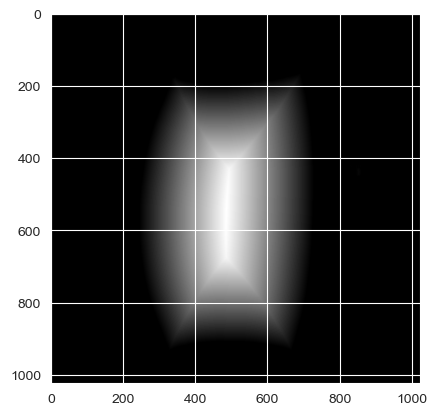

In [6]:
from scipy.ndimage import distance_transform_edt

full_locs = tifffile.imread(r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_02_06\full_locs.tif")
dis = distance_transform_edt(1 - np.isnan(full_locs[..., 0]))

plt.imshow(dis[0], cmap="gray")
plt.show()